# Looking at implied operating hours

In [1]:
import pandas as pd
import hillmaker as hm

## Implied operating hours

Playing off of the same example we walked through in the section [Using the object oriented API](https://hillmaker.readthedocs.io/en/latest/using_oo_api.html), let's say that we are interested in seeing how long the short stay unit is typically open for. There is a method, `compute_implied_operating_hours`, that will allow us to do just that.

But first, we need to read in our stops data and initialize a scenario object. We will use the same inputs as the original `scenario_1` example.

In [2]:
ssu_stopdata = 'https://raw.githubusercontent.com/misken/hillmaker-examples/main/data/ssu_2024.csv'
# ssu_stopdata = './data/ssu_2024.csv'
stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
stops_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [3]:
# Required inputs
scenario_name = 'ssu_oo_1'
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '2024-06-01'
end_date = pd.Timestamp('8/31/2024')

# Optional inputs
cat_field_name = 'PatType'
bin_size_minutes = 60

In [4]:
scenario_1 = hm.Scenario(scenario_name=scenario_name, 
                         data=stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         bin_size_minutes=bin_size_minutes)

Since we do not want a bunch of plots generated, we will use the method `compute_hills_stats`. This function is very similar to `make_hills`, but the majority of the plot creation is suppressed by default.

In [5]:
scenario_1.compute_hills_stats()

## The `compute_implied_operating_hours` method

The method `compute_implied_operating_hours` determines the time a unit opens and closes based on a threshold occupancy statistic. By default, it looks at **20 percent of the mean occupancy** as the threshold. When this target is first breached, the unit is considered open. When occupancy dips below this number, the unit is then considered closed. The difference between these two times is the implied operating hours of the unit.

Of course, the `threshold` value can be adjusted based on your use case. A value of 20 percent still allows a not insignificant portion of patients to occupy the unit and be considered closed.

Let's see what other options we can adjust with this method:

In [6]:
hm.Scenario.compute_implied_operating_hours?

Signature:
hm.Scenario.compute_implied_operating_hours(
    self,
    by_category: bool = True,
    statistic: str = 'mean',
    threshold: float = 0.2,
)
Docstring:
Infers operating hours of underlying data.

Computes implied operating hours based on exceeding a percentage of the
maximum occupancy for a given statistic.

Parameters
----------
by_category : bool
    Default=True corresponds to category specific statistics. A value of False gives overall statistics.

statistic : str
    Column name for the statistic value. Default is 'mean'.

threshold : float
    Percentage of maximum occupancy that will be considered 'open' for
    operating purposes, inclusive. Default is 0.2.

Returns
-------
pandas styler object
File:      ~/Documents/projects/hillmaker/src/hillmaker/scenario.py
Type:      function

We can see there is the ability to look at operating hours by category. This can be helpful to quickly determine if certain subsets of our data, in this case procedural groups, have vastly different daily occupied hours.

For a first pass, let's look at operating hours overall and not by category:

In [7]:
scenario_1.compute_implied_operating_hours(by_category=False)

Day of Week,Start Time,End Time,Hours Open,Peak Occupancy,Peak Occupancy Time
Mon,7,22,15,94.19,12
Tue,7,22,15,84.75,13
Wed,7,21,14,80.98,12
Thu,7,21,14,81.08,12
Fri,7,22,15,94.44,12
Sat,,,,,
Sun,,,,,


Based on this summary table, the unit seems to be open from 7a to 10p Monday through Friday. Wednesday and Thursday might close a bit early, but it is remarkably consistent otherwise. It is closed on the weekends. 

You also see that the table supplies us with additional information, including the peak occupancy and the hour of day that occurred for each day of week.

## Implied versus true operating hours

An important note here is that this is the *implied* operating hours, not the true operating hours. Let's create an occupancy plot to refresh ourselves of what it looks like for this cohort:

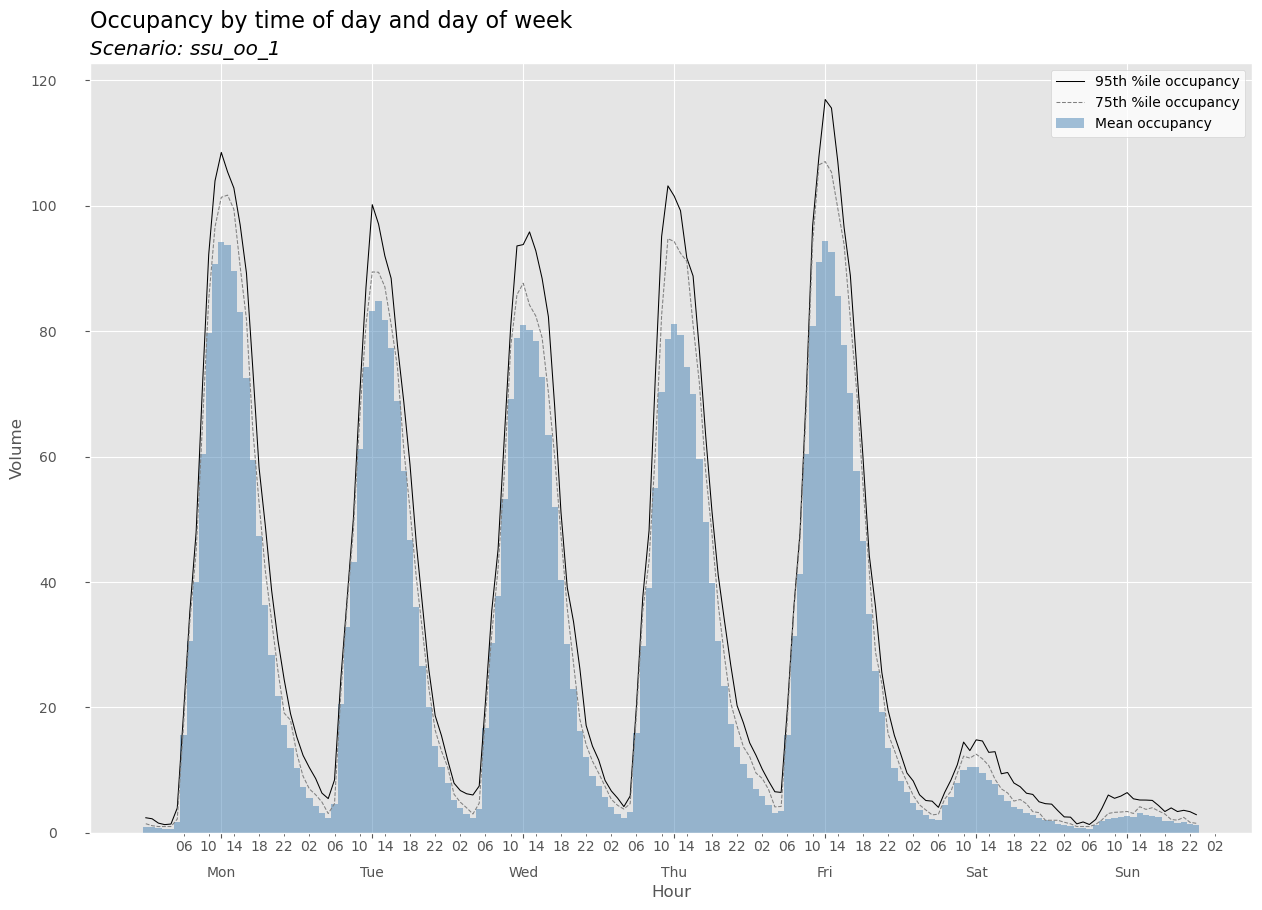

In [8]:
scenario_1.make_weekly_plot()

Based on this graph, the unit appears as if it never closes. Certainly there are periods of lower census, but there are always patients occupying at least one bed on average. The implied operating hours can be helpful to determine when the most staff need to be present on the unit.

## Categorical analysis

If we look at the implied operating hours by `PatType`, do we see major differences depending on the surgical group?

In [9]:
scenario_1.compute_implied_operating_hours()

Based on the above, the CAT cohort of patients are on the unit the longest on average. Notably, the unit starts a little bit later and isopen unil around midnight. In sharp contrast, if only the MYE group was included, the unit would only be open for only one hour on Fridays.

## What-if analysis

Let's say the hospital is intersted in creating a recovery unit dedicated just to ART an MYE patients. Perhaps they require similar skill sets from the nurses who care for them. How long would the core staff need to be present on each day of the week? This brings us to the true power of implied operating hours: what if analysis.

In [10]:
cats_to_include = ['ART', 'MYE']
art_mye_stops_df = stops_df[stops_df['PatType'].isin(cats_to_include)].copy()

Of course, we could have also made use of the `cats_to_exclude` parameter for the `Scenario` object as well. Now we will initialize our new scenario and compute the hills.

In [11]:
# update sceanrio name
scenario_name = 'ssu_art_mye_only'

scenario_2 = hm.Scenario(scenario_name=scenario_name, 
                         data=art_mye_stops_df,
                         in_field=in_field_name,
                         out_field=out_field_name,
                         start_analysis_dt=start_date,
                         end_analysis_dt=end_date,
                         cat_field=cat_field_name,
                         bin_size_minutes=bin_size_minutes)

In [12]:
scenario_2.compute_hills_stats()

Let's change the `threshold` to 10 percent since MYE was barely picked up when it was 20 percent.

In [13]:
scenario_2.compute_implied_operating_hours(by_category=False, threshold=0.1)

Day of Week,Start Time,End Time,Hours Open,Peak Occupancy,Peak Occupancy Time
Mon,6,19,13,21.82,11
Tue,7,20,13,19.13,12
Wed,6,20,14,20.36,11
Thu,6,19,13,19.50,10
Fri,6,19,13,23.55,11
Sat,,,,,
Sun,,,,,


This makes sense because the ART group is the bottleneck in this case. They have the greater volume and operate on more days of week. So the implied operating hours takes more after the ART than the MYE patients.

Now let's confirm this against the true occupancy plot:

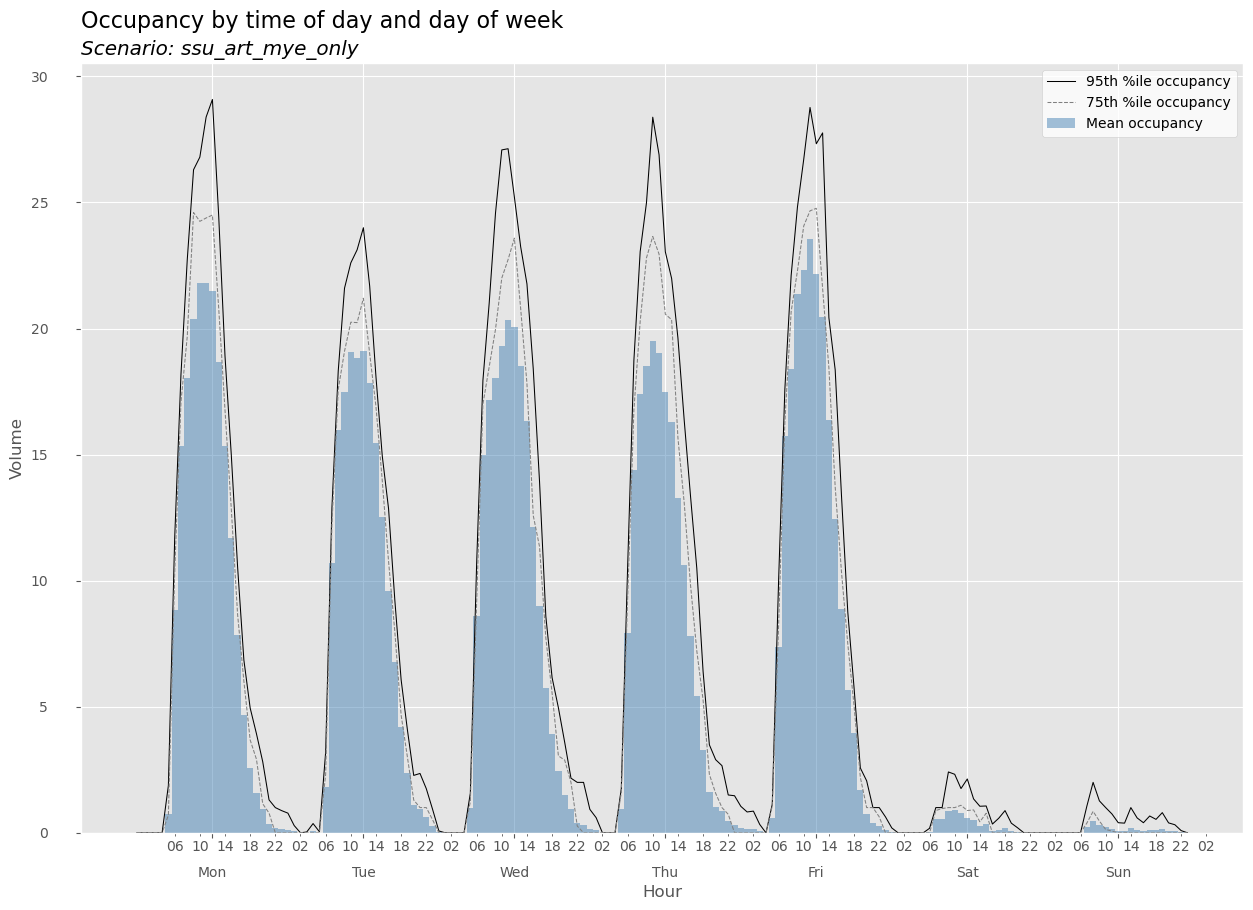

In [14]:
scenario_2.make_weekly_plot()

The unit does appear to have a low enough volume to essentially close overnight, which is reflected in the implied operating hours as well.